In [61]:
# Note ->
# https://docs.google.com/document/d/1YwC5URk4_qqMq1PMHV12hBXpbnKMR5h48wzmpHIZgss/edit
# Exercise ->
# https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

In [62]:
# array python
import pandas as pd
import numpy as np

# metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# encoders
import category_encoders as ce

# model validation
from sklearn.model_selection import cross_val_score, cross_validate, validation_curve, learning_curve

%matplotlib inline

### Helpers

In [63]:
def get_text_columns(d):
    current_filter = d.dtypes == object
    columns = [c for c in current_filter.index if current_filter[c]]
    
    return columns

def confusion_matrix(y_test, predicted):
    confusion_matrix = metrics.confusion_matrix(y_test, predicted)
    class_name = [0, 1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_name))
    plt.xticks(tick_marks, class_name)
    plt.yticks(tick_marks, class_name)

    sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap='Blues_r', fmt='g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion Matrix', y=1.1)
    plt.ylabel('Current Label')
    plt.xlabel('Predicted Label')

def test_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    y_predicted = model.predict(X_test)
    
    confusion_matrix(y_test, y_predicted)
    
    return (model, score, y_predicted)

def test_model_cross_val(model, X, y, cv=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    result = cross_val_score(model, X_train, y_train, cv=cv)
    
    return np.mean(result)

def test_model_cross_validate(model, X, y, cv=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    result = cross_validate(model, X_train, y_train, return_train_score=True, cv=cv)
    
    test_score = result['test_score']
    train_score = result['train_score']
    
    print('test_score', np.mean(test_score))
    print('train_score', np.mean(train_score))
    
def test_model_validation_curve(model, param_name, param_range, cv=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    train_scores, test_scores = validation_curve(
        model,
        X_train,
        y_train,
        param_name=param_name,
        param_range=param_range,
        cv=cv)
    
    np.mean(train_scores, axis=1)
    np.mean(train_scores, axis=1)
    
    plt.plot(np.mean(train_scores, axis=1))
    plt.plot(np.mean(test_scores, axis=1))
    plt.xticks(np.arange(len(param_range)), param_range)
    
    
def test_learning_curve(model, X, y, cv=5):
    lc = learning_curve(model, X, y, cv=cv)
    samples, train, test = lc[0], lc[1], lc[2]
    plt.plot(samples[1:], np.mean(train, axis=1)[1:])
    plt.plot(samples[1:], np.mean(test, axis=1)[1:])

### Datasets and informations

In [64]:
train = pd.read_csv('./aug_train.csv')
test = pd.read_csv('./aug_test.csv')

In [65]:
# train info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [66]:
# length
train.shape

(19158, 14)

In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


In [68]:
test.shape

(2129, 13)

### Features

- **enrollee_id:** Unique ID for candidate
- **city:** City code
- **city_ development _index:** Developement index of the city (scaled)
- **gender:** Gender of candidate
- **relevent_experience:** Relevant experience of candidate
- **enrolled_university:** Type of University course enrolled if any
- **education_level:** Education level of candidate
- **major_discipline:** Education major discipline of candidate
- **experience:** Candidate total experience in years
- **company_size:** No of employees in current employer's company
- **company_type:** Type of current employer
- **lastnewjob:** Difference in years between previous job and current job
- **training_hours:** training hours completed
- **target:** 0 – Not looking for job change, 1 – Looking for a job change

In [69]:
test.head(2)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98


In [70]:
train.head(2)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0


### Categorical column coding

In [71]:
cat_cols = get_text_columns(train)
cat_cols

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [72]:
encoder = ce.BinaryEncoder(cols=cat_cols)
train_binenc = encoder.fit_transform(train)
test_binenc = encoder.fit_transform(test)

In [73]:
train_binenc.head()

,enrollee_id,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_development_index,...,company_type_0,company_type_1,company_type_2,company_type_3,last_new_job_0,last_new_job_1,last_new_job_2,last_new_job_3,training_hours,target
0,8949,0,0,0,0,0,0,0,1,0.920,...,0,0,0,1,0,0,0,1,36,1.0
1,29725,0,0,0,0,0,0,1,0,0.776,...,0,0,1,0,0,0,1,0,47,0.0
2,11561,0,0,0,0,0,0,1,1,0.624,...,0,0,0,1,0,0,1,1,83,0.0
3,33241,0,0,0,0,0,1,0,0,0.789,...,0,0,1,0,0,0,1,1,52,1.0
4,666,0,0,0,0,0,1,0,1,0.767,...,0,0,1,1,0,1,0,0,8,0.0


In [74]:
test_binenc.head()

,enrollee_id,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_development_index,...,company_size_4,company_type_0,company_type_1,company_type_2,company_type_3,last_new_job_0,last_new_job_1,last_new_job_2,last_new_job_3,training_hours
0,32403,0,0,0,0,0,0,0,1,0.827,...,1,0,0,0,1,0,0,0,1,21
1,9858,0,0,0,0,0,0,1,0,0.920,...,0,0,0,1,0,0,0,0,1,98
2,31806,0,0,0,0,0,0,1,1,0.624,...,0,0,0,1,0,0,0,1,0,15
3,27385,0,0,0,0,0,1,0,0,0.827,...,1,0,0,1,0,0,0,0,1,39
4,27724,0,0,0,0,0,0,1,0,0.920,...,0,0,0,1,0,0,0,1,1,72


### Train and selected model

In [77]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble, tree

In [78]:
y = train_binenc['target']
X = train_binenc.drop(['target', 'enrollee_id'], axis=1)
X_test2 = test_binenc.drop(['enrollee_id'], axis=1)

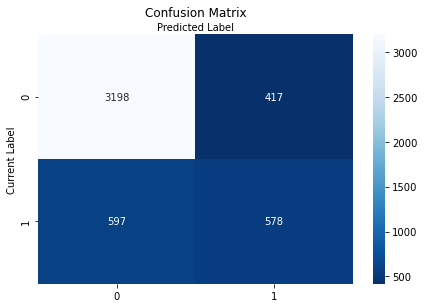

In [79]:
(model, score, y_predicted) = test_model(ensemble.GradientBoostingClassifier(), X, y)

In [80]:
score

0.7883089770354906

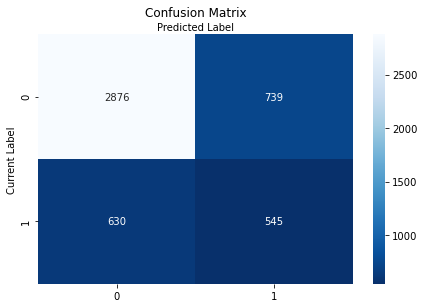

In [81]:
(model, score, y_predicted) = test_model(tree.DecisionTreeClassifier(), X, y)

In [82]:
score

0.7141962421711899

### Validation

In [83]:
test_model_cross_validate(ensemble.GradientBoostingClassifier(), X, y)

test_score 0.789670754591073
train_score 0.8035216891344031


In [ ]:
# test_model_validation_curve(
#     ensemble.GradientBoostingClassifier(),
#     param_name='n_estimators',
#     param_range=np.arange(80, 100, 10))

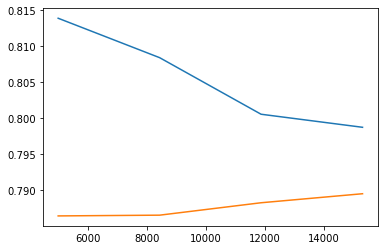

In [84]:
test_learning_curve(ensemble.GradientBoostingClassifier(), X, y)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [85]:
from sklearn.model_selection import GridSearchCV

In [86]:
param_test1 = {'n_estimators': np.arange(20, 501, 20)}

In [87]:
model_test = ensemble.GradientBoostingClassifier(
    learning_rate=0.1,
    min_samples_split=500,
    min_samples_leaf=50,
    max_depth=8,
    max_features='sqrt',
    subsample=0.8,
    random_state=10,
)

In [ ]:
gridSearch = GridSearchCV(model_test, param_grid=param_test1, scoring='r2', cv=5)
gridSearch.fit(X_train, y_train)

In [ ]:

# gridSearch.best_score_
# gridSearch.best_estimator_

gridSearch.best_params_ 

In [ ]:
r = cross_validate(gridSearch.best_estimator_, X_train, y_train, return_train_score=True)
test_score = r['test_score']
train_score = r['train_score']

print('test_score', np.mean(test_score))
print('train_score', np.mean(train_score))

### Final model

In [ ]:
model = ensemble.GradientBoostingClassifier(
    learning_rate=0.1,
    min_samples_split=500,
    min_samples_leaf=50,
    max_depth=8,
    max_features='sqrt',
    subsample=0.8,
    random_state=10,
    n_estimators=80,
)

model.fit(X_train, y_train)
score = model.score(X_test, y_test)

In [ ]:
score

In [ ]:
model.predict()